# Spectral Map

In [1]:
# import necessary Python packages
import os
import numpy as np 
import pandas as pd 
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import networkx as nx

## Reference object

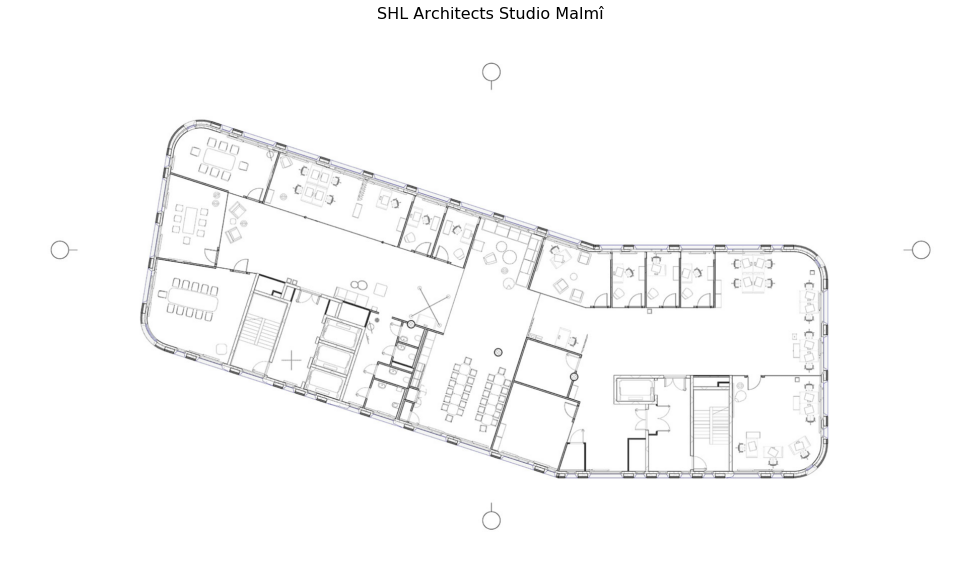

In [2]:
img=mpimg.imread('data/layout.jpg')
fig = plt.figure(figsize = (30,10))
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(img, interpolation="bilinear")
plt.axis('off')
a.set_title('SHL Architects Studio Malmî', fontsize=16);

## Get structured data

In [3]:
# Load data 
rooms = pd.read_csv('data/room_schedule.csv', skiprows=[2], keep_default_na=False)
rooms.columns = rooms.iloc[0]
rooms.drop([0], inplace=True)
rooms['Area'] = rooms['Area'].map(lambda x: x.rstrip(' m²'))
rooms

,Number,Name,Area,Perimeter
1,1,CTO Office,9.52,12794
2,2,Legal Eagle Office,9.51,12786
3,3,PA Office,9.51,12786
4,4,CEO Office,21.62,18879
5,5,HR Office,9.30,12587
6,6,CFO Office,9.25,12565
7,7,Sales Arena,39.79,28112
8,8,Swedese,26.82,21385
9,9,Offecct,25.06,20274
10,10,WC1,2.21,5951


In [4]:
# Load data 
doors = pd.read_csv('data/door_schedule.csv', skiprows=[2], keep_default_na=False)
doors.columns = doors.iloc[0]
doors.drop([0], inplace=True)
doors

,Mark,From Room: Number,To Room: Number,Rough Width,Rough Height
1,632296,1,16,1015,2102
2,642739,2,16,1015,2102
3,650548,3,16,1015,2102
4,196335,4,16,1015,2102
5,654502,6,16,1015,2102
6,320281,7,16,970,1680
7,320293,7,16,970,1680
8,655552,8,16,1015,2102
9,652881,9,16,1015,2102
10,542383,10,16,810,1900


In [5]:
doors['From Room: Number'][:-1] = doors['From Room: Number'][:-1].map(lambda k: rooms["Name"][int(k)])
doors['To Room: Number'][:-1] = doors['To Room: Number'][:-1].map(lambda k: rooms["Name"][int(k)])

In [6]:
doors = doors.rename(columns={'From Room: Number': 'From Room', 'To Room: Number': 'To Room', 'Rough Width': 'Width', 'Rough Height': 'Height'})
doors

,Mark,From Room,To Room,Width,Height
1,632296,CTO Office,Open,1015,2102
2,642739,Legal Eagle Office,Open,1015,2102
3,650548,PA Office,Open,1015,2102
4,196335,CEO Office,Open,1015,2102
5,654502,CFO Office,Open,1015,2102
6,320281,Sales Arena,Open,970,1680
7,320293,Sales Arena,Open,970,1680
8,655552,Swedese,Open,1015,2102
9,652881,Offecct,Open,1015,2102
10,542383,WC1,Open,810,1900


## Preprocessing

In [7]:
def plotDataAndCov(data):
    ACov = np.cov(data, rowvar=False, bias=True)
    print('Covariance matrix:\n', ACov)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(10, 10)

    ax0 = plt.subplot(2, 2, 1)
    
    # Choosing the colors
    cmap = sns.color_palette("GnBu", 10)
    sns.heatmap(ACov, cmap=cmap, vmin=0)

    ax1 = plt.subplot(2, 2, 2)
    
    # data can include the colors
    if data.shape[1]==3:
        c=data[:,2]
    else:
        c="#0A98BE"
    ax1.scatter(data[:,0], data[:,1], c=c, s=40)
    
    # Remove the top and right axes from the data plot
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

In [8]:
def calculateCovariance(X):
    meanX = np.mean(X, axis = 0)
    lenX = X.shape[0]
    X = X - meanX
    covariance = X.T.dot(X)/lenX
    return covariance

In [9]:
def center(X):
    newX = X - np.mean(X, axis = 0)
    return newX

In [10]:
def standardize(X):
    newX = center(X)/np.std(X, axis = 0)
    return newX

In [11]:
def whiten(X):
    cov = X.T.dot(X)/float(X.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X.dot(eigVecs)
    # Rescale the decorrelated data
    whitened = decorrelated / np.sqrt(eigVals + 1e-5)
    return whitened

### Preprocessing rooms

In [12]:
ra = np.array(rooms['Area']).astype(float)
rp = np.array(rooms['Perimeter']).astype(int)

In [13]:
R = np.array([ra, rp]).T
R.shape

(25, 2)

Covariance matrix:
 [[4.35007358e+03 2.05336376e+06]
 [2.05336376e+06 9.72926609e+08]]


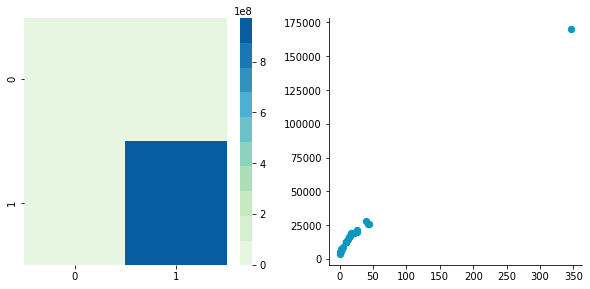

In [14]:
plotDataAndCov(R)
plt.show()
plt.close()

Covariance matrix:
 [[4.35007358e+03 2.05336376e+06]
 [2.05336376e+06 9.72926609e+08]]


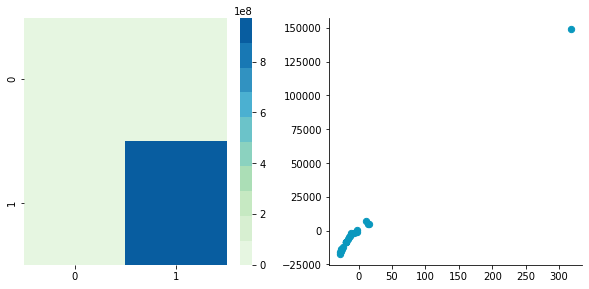

In [15]:
R = center(R)
plotDataAndCov(R)
plt.show()
plt.close()

Covariance matrix:
 [[1.         0.99810803]
 [0.99810803 1.        ]]


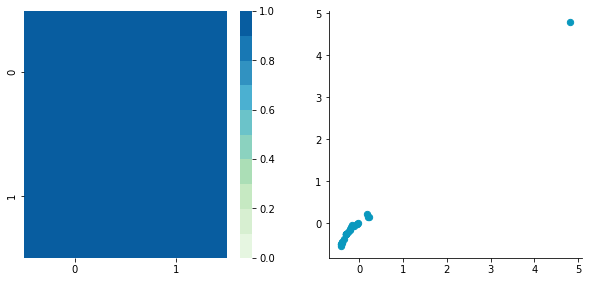

In [16]:
R = standardize(R)
plotDataAndCov(R)
plt.show()
plt.close()

Covariance matrix:
 [[ 9.94742282e-01 -3.24338527e-15]
 [-3.24338527e-15  9.99994995e-01]]


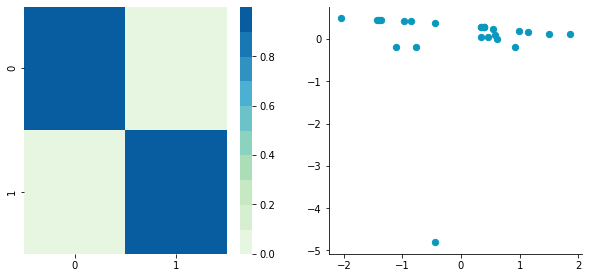

In [17]:
R = whiten(R)
plotDataAndCov(R)
plt.show()
plt.close()

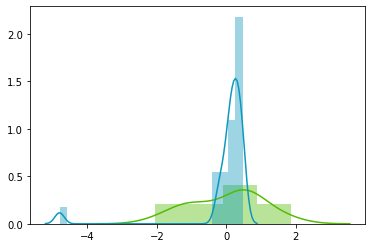

In [18]:
sns.distplot(R[:,0], color="#53BB04")
sns.distplot(R[:,1], color="#0A98BE")
plt.show()
plt.close()

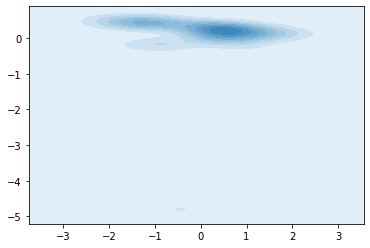

In [19]:
sns.kdeplot(R[:,0], R[:,1], shade=True);

### Preprocessing doors

In [20]:
dw = np.array(doors['Width'][:-1]).astype(int)
dh = np.array(doors['Height'][:-1]).astype(int)

In [21]:
bond = dw*dh
bond = bond/bond.max()
bond

array([0.49202758, 0.49202758, 0.49202758, 0.49202758, 0.49202758,
       0.37581292, 0.37581292, 0.49202758, 0.49202758, 0.35491905,
       0.35491905, 0.49202758, 0.49202758, 0.35491905, 0.35491905,
       0.48913795, 0.49202758, 0.35491905, 0.49202758, 0.48913795,
       0.77226327, 0.48913795, 0.77226327, 0.48913795, 1.        ,
       0.73128546])

In [22]:
B = np.array([dw, dh]).T
B.shape

(26, 2)

Covariance matrix:
 [[78489.07248521 15016.40236686]
 [15016.40236686 16871.62130178]]


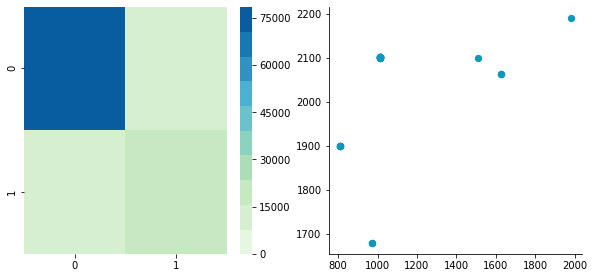

In [23]:
plotDataAndCov(B)
plt.show()
plt.close()

Covariance matrix:
 [[78489.07248521 15016.40236686]
 [15016.40236686 16871.62130178]]


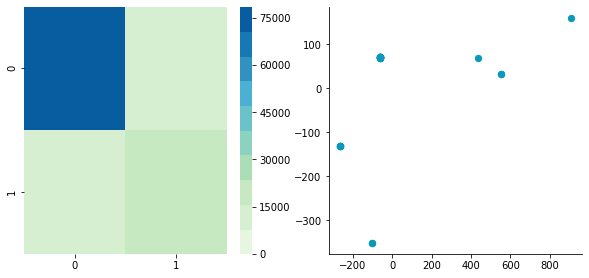

In [24]:
B = center(B)
plotDataAndCov(B)
plt.show()
plt.close()

Covariance matrix:
 [[1.         0.41265099]
 [0.41265099 1.        ]]


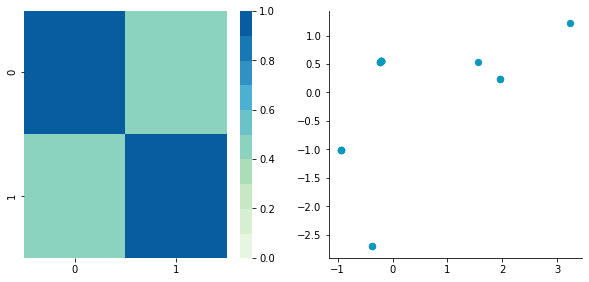

In [25]:
B = standardize(B)
plotDataAndCov(B)
plt.show()
plt.close()

Covariance matrix:
 [[9.99992921e-01 6.98715852e-17]
 [6.98715852e-17 9.99982975e-01]]


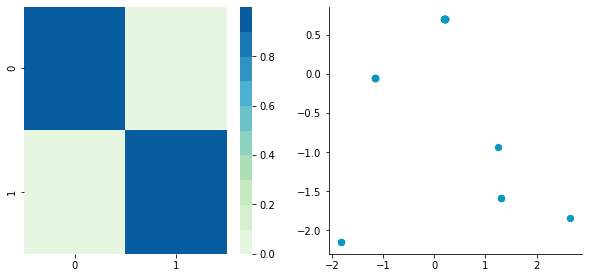

In [26]:
B = whiten(B)
plotDataAndCov(B)
plt.show()
plt.close()

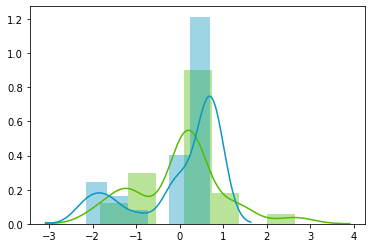

In [27]:
sns.distplot(B[:,0], color="#53BB04")
sns.distplot(B[:,1], color="#0A98BE")
plt.show()
plt.close()

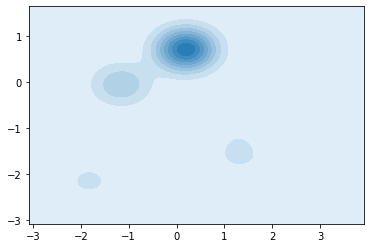

In [28]:
sns.kdeplot(B[:,0], B[:,1], shade=True);

## Graph construction

In [29]:
fr = np.array(doors['From Room'][:-1])
to = np.array(doors['To Room'][:-1])

In [30]:
pairs = np.vstack((fr, to)).T
pairs

array([['CTO Office', 'Open'],
       ['Legal Eagle Office', 'Open'],
       ['PA Office', 'Open'],
       ['CEO Office', 'Open'],
       ['CFO Office', 'Open'],
       ['Sales Arena', 'Open'],
       ['Sales Arena', 'Open'],
       ['Swedese', 'Open'],
       ['Offecct', 'Open'],
       ['WC1', 'Open'],
       ['WC3', 'Open'],
       ['VR Room', 'Open'],
       ['Open', 'HR Office'],
       ['Open', 'WC2'],
       ['Open', 'WC4'],
       ['Open', 'Copy'],
       ['Open', 'EFG'],
       ['Open', 'Storage'],
       ['Marketing', 'Open'],
       ['Recovery', 'Open'],
       ['Entrance1', 'Open'],
       ['Entrance1', 'Stairs1'],
       ['Entrance2', 'Open'],
       ['Entrance2', 'Stairs2'],
       ['Entrance2', 'Revision'],
       ['Revision', 'Open']], dtype=object)

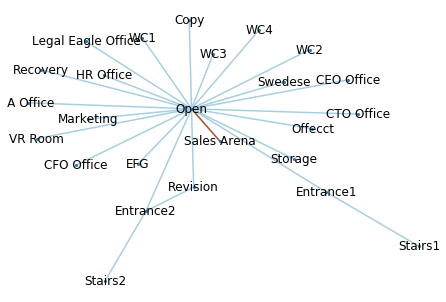

In [31]:
import warnings
warnings.filterwarnings("ignore")
 
# Create a networkx graph object
G = nx.MultiGraph() 
 
# Add edges to to the graph object
# Each tuple represents an edge between two nodes
G.add_edges_from(pairs[:, [0, 1]])
c = np.array(G.edges).T[2].astype(int)
my_pos = nx.spring_layout(G, seed = 56)
# Draw the resulting graph
nx.draw(G, pos=my_pos, with_labels=True, edge_color=c, width=1.5, node_size=4, edge_cmap=plt.cm.Paired)

In [32]:
pairs = np.vstack((fr, to, c)).T
pairs

array([['CTO Office', 'Open', 0],
       ['Legal Eagle Office', 'Open', 0],
       ['PA Office', 'Open', 0],
       ['CEO Office', 'Open', 0],
       ['CFO Office', 'Open', 0],
       ['Sales Arena', 'Open', 0],
       ['Sales Arena', 'Open', 1],
       ['Swedese', 'Open', 0],
       ['Offecct', 'Open', 0],
       ['WC1', 'Open', 0],
       ['WC3', 'Open', 0],
       ['VR Room', 'Open', 0],
       ['Open', 'HR Office', 0],
       ['Open', 'WC2', 0],
       ['Open', 'WC4', 0],
       ['Open', 'Copy', 0],
       ['Open', 'EFG', 0],
       ['Open', 'Storage', 0],
       ['Marketing', 'Open', 0],
       ['Recovery', 'Open', 0],
       ['Entrance1', 'Open', 0],
       ['Entrance1', 'Stairs1', 0],
       ['Entrance2', 'Open', 0],
       ['Entrance2', 'Stairs2', 0],
       ['Entrance2', 'Revision', 0],
       ['Revision', 'Open', 0]], dtype=object)

In [33]:
G.nodes(data=True)

NodeDataView({'CTO Office': {}, 'Open': {}, 'Legal Eagle Office': {}, 'PA Office': {}, 'CEO Office': {}, 'CFO Office': {}, 'Sales Arena': {}, 'Swedese': {}, 'Offecct': {}, 'WC1': {}, 'WC3': {}, 'VR Room': {}, 'HR Office': {}, 'WC2': {}, 'WC4': {}, 'Copy': {}, 'EFG': {}, 'Storage': {}, 'Marketing': {}, 'Recovery': {}, 'Entrance1': {}, 'Stairs1': {}, 'Entrance2': {}, 'Stairs2': {}, 'Revision': {}})

In [34]:
G.edges(data=True,keys=True)

MultiEdgeDataView([('CTO Office', 'Open', 0, {}), ('Open', 'Legal Eagle Office', 0, {}), ('Open', 'PA Office', 0, {}), ('Open', 'CEO Office', 0, {}), ('Open', 'CFO Office', 0, {}), ('Open', 'Sales Arena', 0, {}), ('Open', 'Sales Arena', 1, {}), ('Open', 'Swedese', 0, {}), ('Open', 'Offecct', 0, {}), ('Open', 'WC1', 0, {}), ('Open', 'WC3', 0, {}), ('Open', 'VR Room', 0, {}), ('Open', 'HR Office', 0, {}), ('Open', 'WC2', 0, {}), ('Open', 'WC4', 0, {}), ('Open', 'Copy', 0, {}), ('Open', 'EFG', 0, {}), ('Open', 'Storage', 0, {}), ('Open', 'Marketing', 0, {}), ('Open', 'Recovery', 0, {}), ('Open', 'Entrance1', 0, {}), ('Open', 'Entrance2', 0, {}), ('Open', 'Revision', 0, {}), ('Entrance1', 'Stairs1', 0, {}), ('Entrance2', 'Stairs2', 0, {}), ('Entrance2', 'Revision', 0, {})])

## Embed Attributes

In [35]:
weight = 0
width = 0
height = 0
nx.set_edge_attributes(G, weight, 'weight')
nx.set_edge_attributes(G, width, 'width')
nx.set_edge_attributes(G, height, 'height')

In [36]:
G.edges(data=True,keys=True)

MultiEdgeDataView([('CTO Office', 'Open', 0, {'weight': 0, 'width': 0, 'height': 0}), ('Open', 'Legal Eagle Office', 0, {'weight': 0, 'width': 0, 'height': 0}), ('Open', 'PA Office', 0, {'weight': 0, 'width': 0, 'height': 0}), ('Open', 'CEO Office', 0, {'weight': 0, 'width': 0, 'height': 0}), ('Open', 'CFO Office', 0, {'weight': 0, 'width': 0, 'height': 0}), ('Open', 'Sales Arena', 0, {'weight': 0, 'width': 0, 'height': 0}), ('Open', 'Sales Arena', 1, {'weight': 0, 'width': 0, 'height': 0}), ('Open', 'Swedese', 0, {'weight': 0, 'width': 0, 'height': 0}), ('Open', 'Offecct', 0, {'weight': 0, 'width': 0, 'height': 0}), ('Open', 'WC1', 0, {'weight': 0, 'width': 0, 'height': 0}), ('Open', 'WC3', 0, {'weight': 0, 'width': 0, 'height': 0}), ('Open', 'VR Room', 0, {'weight': 0, 'width': 0, 'height': 0}), ('Open', 'HR Office', 0, {'weight': 0, 'width': 0, 'height': 0}), ('Open', 'WC2', 0, {'weight': 0, 'width': 0, 'height': 0}), ('Open', 'WC4', 0, {'weight': 0, 'width': 0, 'height': 0}), ('Ope

In [37]:
for i, pair in enumerate(pairs):
    G.edges[(pair[0], pair[1], pair[2])]['weight'] = bond[i]
    G.edges[(pair[0], pair[1], pair[2])]['width'] = dw[i]
    G.edges[(pair[0], pair[1], pair[2])]['height'] = dh[i]

In [38]:
G.edges(data=True,keys=True)

MultiEdgeDataView([('CTO Office', 'Open', 0, {'weight': 0.49202758175360917, 'width': 1015, 'height': 2102}), ('Open', 'Legal Eagle Office', 0, {'weight': 0.49202758175360917, 'width': 1015, 'height': 2102}), ('Open', 'PA Office', 0, {'weight': 0.49202758175360917, 'width': 1015, 'height': 2102}), ('Open', 'CEO Office', 0, {'weight': 0.49202758175360917, 'width': 1015, 'height': 2102}), ('Open', 'CFO Office', 0, {'weight': 0.49202758175360917, 'width': 1015, 'height': 2102}), ('Open', 'Sales Arena', 0, {'weight': 0.37581292375812925, 'width': 970, 'height': 1680}), ('Open', 'Sales Arena', 1, {'weight': 0.37581292375812925, 'width': 970, 'height': 1680}), ('Open', 'Swedese', 0, {'weight': 0.49202758175360917, 'width': 1015, 'height': 2102}), ('Open', 'Offecct', 0, {'weight': 0.49202758175360917, 'width': 1015, 'height': 2102}), ('Open', 'WC1', 0, {'weight': 0.3549190535491905, 'width': 810, 'height': 1900}), ('Open', 'WC3', 0, {'weight': 0.3549190535491905, 'width': 810, 'height': 1900}

In [39]:
# create weighted graph from G
N = nx.Graph()
for u,v,data in G.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if N.has_edge(u,v):
        N[u][v]['weight'] += w
    else:
        N.add_edge(u, v, weight=w)

In [40]:
N.edges(data=True)

EdgeDataView([('CTO Office', 'Open', {'weight': 0.49202758175360917}), ('Open', 'Legal Eagle Office', {'weight': 0.49202758175360917}), ('Open', 'PA Office', {'weight': 0.49202758175360917}), ('Open', 'CEO Office', {'weight': 0.49202758175360917}), ('Open', 'CFO Office', {'weight': 0.49202758175360917}), ('Open', 'Sales Arena', {'weight': 0.7516258475162585}), ('Open', 'Swedese', {'weight': 0.49202758175360917}), ('Open', 'Offecct', {'weight': 0.49202758175360917}), ('Open', 'WC1', {'weight': 0.3549190535491905}), ('Open', 'WC3', {'weight': 0.3549190535491905}), ('Open', 'VR Room', {'weight': 0.49202758175360917}), ('Open', 'HR Office', {'weight': 0.49202758175360917}), ('Open', 'WC2', {'weight': 0.3549190535491905}), ('Open', 'WC4', {'weight': 0.3549190535491905}), ('Open', 'Copy', {'weight': 0.48913795489137957}), ('Open', 'EFG', {'weight': 0.49202758175360917}), ('Open', 'Storage', {'weight': 0.3549190535491905}), ('Open', 'Marketing', {'weight': 0.49202758175360917}), ('Open', 'Rec

In [41]:
N.nodes.data()

NodeDataView({'CTO Office': {}, 'Open': {}, 'Legal Eagle Office': {}, 'PA Office': {}, 'CEO Office': {}, 'CFO Office': {}, 'Sales Arena': {}, 'Swedese': {}, 'Offecct': {}, 'WC1': {}, 'WC3': {}, 'VR Room': {}, 'HR Office': {}, 'WC2': {}, 'WC4': {}, 'Copy': {}, 'EFG': {}, 'Storage': {}, 'Marketing': {}, 'Recovery': {}, 'Entrance1': {}, 'Entrance2': {}, 'Revision': {}, 'Stairs1': {}, 'Stairs2': {}})

In [42]:
for i, node in enumerate(rooms['Name']):
    N.nodes[node]['area'] = ra[i]

In [43]:
N.nodes.data()

NodeDataView({'CTO Office': {'area': 9.52}, 'Open': {'area': 345.81}, 'Legal Eagle Office': {'area': 9.51}, 'PA Office': {'area': 9.51}, 'CEO Office': {'area': 21.62}, 'CFO Office': {'area': 9.25}, 'Sales Arena': {'area': 39.79}, 'Swedese': {'area': 26.82}, 'Offecct': {'area': 25.06}, 'WC1': {'area': 2.21}, 'WC3': {'area': 2.7}, 'VR Room': {'area': 25.46}, 'HR Office': {'area': 9.3}, 'WC2': {'area': 2.04}, 'WC4': {'area': 5.24}, 'Copy': {'area': 12.42}, 'EFG': {'area': 41.9}, 'Storage': {'area': 0.82}, 'Marketing': {'area': 43.32}, 'Recovery': {'area': 3.01}, 'Entrance1': {'area': 16.98}, 'Entrance2': {'area': 17.59}, 'Revision': {'area': 1.16}, 'Stairs1': {'area': 14.32}, 'Stairs2': {'area': 15.27}})

In [44]:
ec = np.array(list(nx.get_edge_attributes(N,'weight').values()))
len(set(ec))

7

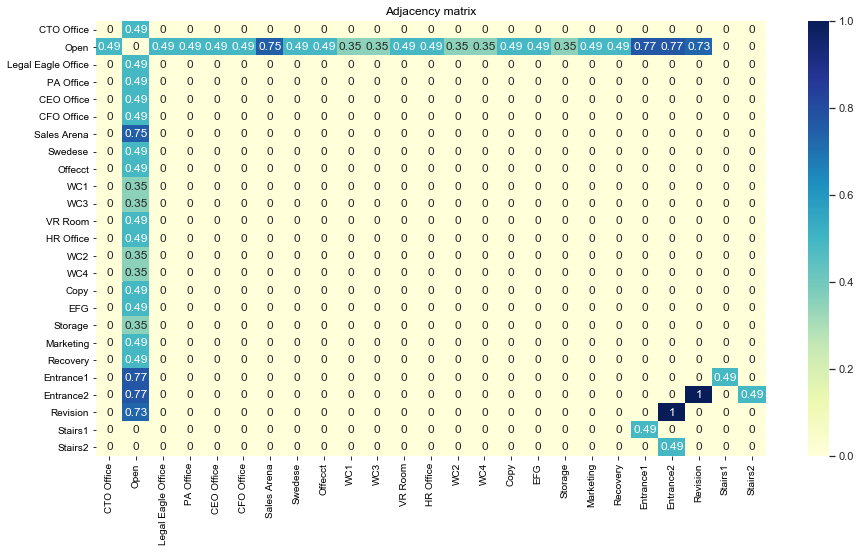

In [45]:
A = nx.to_numpy_matrix(N)
plt.figure(figsize=(15,8))
plt.title('Adjacency matrix')
sns.set()
sns.heatmap(A, cmap="YlGnBu", annot=True, xticklabels=N.nodes, yticklabels=N.nodes);

## Gephi Export

In [46]:
with open("data/spectral_map.graphml", "wb") as ofile:
    nx.write_graphml(N, ofile)

## Get data laboratory results

In [47]:
# Load data 
data = pd.read_csv('data/data_lab.csv')
data = data.rename(columns={'d0': 'area'})
columns = ['Id', 'timeset', 'componentnumber']
data.drop(columns, inplace=True, axis=1)
data

,Label,area,Degree,clustering,triangles,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,eigencentrality,modularity_class,pageranks,Weighted Degree,Authority,Hub
0,CTO Office,9.520000,1,0.000000,0,3,0.489796,0.506944,0.000000,0.209728,0,0.021682,0.492028,0.146680,0.147334
1,Open,345.809998,22,0.004329,1,2,0.923077,0.958333,0.985507,1.000000,0,0.406287,11.192612,0.701230,0.698180
2,Legal Eagle Office,9.510000,1,0.000000,0,3,0.489796,0.506944,0.000000,0.209728,0,0.021682,0.492028,0.146680,0.147334
3,PA Office,9.510000,1,0.000000,0,3,0.489796,0.506944,0.000000,0.209728,0,0.021682,0.492028,0.146680,0.147334
4,CEO Office,21.620001,1,0.000000,0,3,0.489796,0.506944,0.000000,0.209728,0,0.021682,0.492028,0.146680,0.147334
5,CFO Office,9.250000,1,0.000000,0,3,0.489796,0.506944,0.000000,0.209728,0,0.021682,0.492028,0.146680,0.147334
6,Sales Arena,39.790001,1,0.000000,0,3,0.489796,0.506944,0.000000,0.209728,0,0.021682,0.751626,0.146680,0.147334
7,Swedese,26.820000,1,0.000000,0,3,0.489796,0.506944,0.000000,0.209728,0,0.021682,0.492028,0.146680,0.147334
8,Offecct,25.059999,1,0.000000,0,3,0.489796,0.506944,0.000000,0.209728,0,0.021682,0.492028,0.146680,0.147334
9,WC1,2.210000,1,0.000000,0,3,0.489796,0.506944,0.000000,0.209728,0,0.021682,0.354919,0.146680,0.147334


In [48]:
labels = np.array(data['Label'])
print(labels)

['CTO Office' 'Open' 'Legal Eagle Office' 'PA Office' 'CEO Office'
 'CFO Office' 'Sales Arena' 'Swedese' 'Offecct' 'WC1' 'WC3' 'VR Room'
 'HR Office' 'WC2' 'WC4' 'Copy' 'EFG' 'Storage' 'Marketing' 'Recovery'
 'Entrance1' 'Entrance2' 'Revision' 'Stairs1' 'Stairs2']


In [49]:
final_data = np.array(data.drop(['Label'], axis=1))

In [51]:
X = final_data
X.shape

(25, 14)

In [50]:
from sklearn.manifold import Isomap

In [52]:
# apply isomap with k = 24 and output dimension = 3
model = Isomap(n_components=3, n_neighbors=24)
proj = model.fit_transform(X)

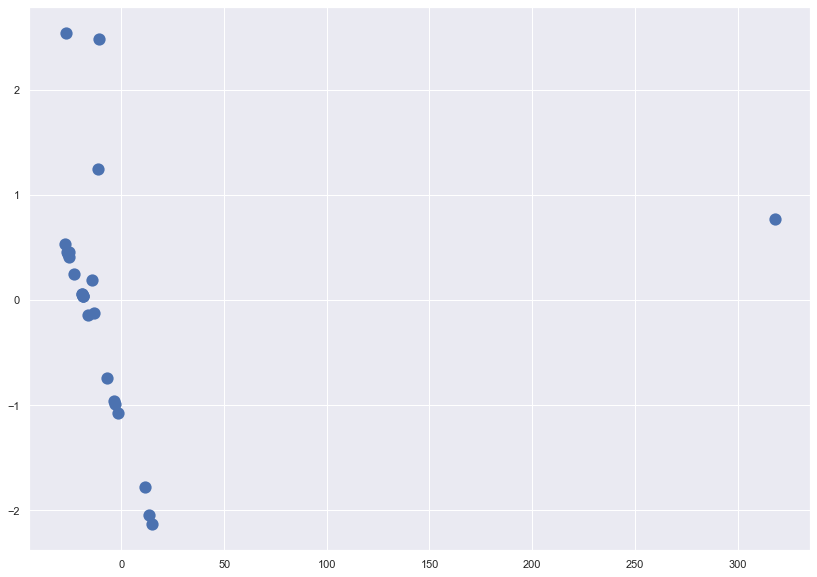

In [53]:
# plot the isomap projection
plt.figure(figsize=(14,10))
plt.scatter(proj[:, 0], proj[:, 1], s=150, lw=0, alpha=1);

In [54]:
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=7)
Kmean.fit(proj)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [55]:
clusters = Kmean.labels_

In [56]:
match = np.vstack((labels, clusters)).T
print(match)

[['CTO Office' 2]
 ['Open' 1]
 ['Legal Eagle Office' 2]
 ['PA Office' 2]
 ['CEO Office' 6]
 ['CFO Office' 2]
 ['Sales Arena' 0]
 ['Swedese' 3]
 ['Offecct' 3]
 ['WC1' 4]
 ['WC3' 4]
 ['VR Room' 3]
 ['HR Office' 2]
 ['WC2' 4]
 ['WC4' 4]
 ['Copy' 2]
 ['EFG' 0]
 ['Storage' 4]
 ['Marketing' 0]
 ['Recovery' 4]
 ['Entrance1' 5]
 ['Entrance2' 5]
 ['Revision' 4]
 ['Stairs1' 5]
 ['Stairs2' 5]]


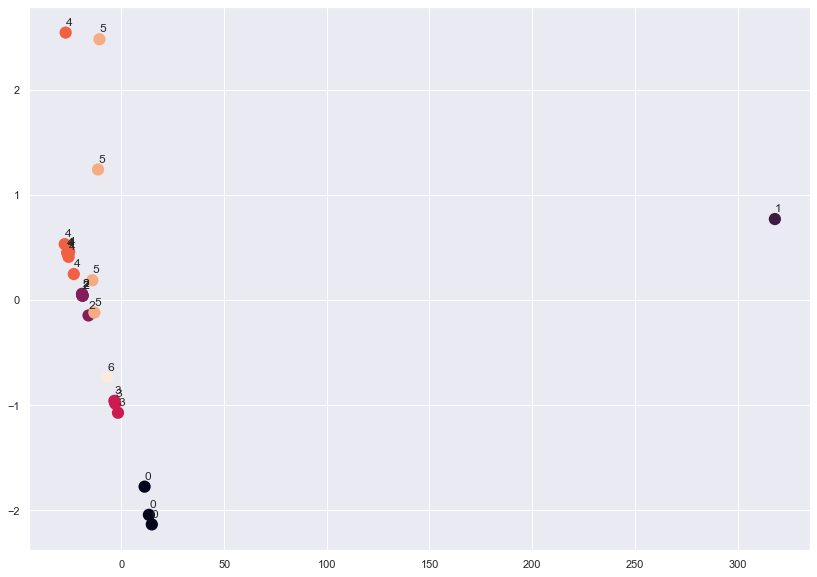

In [57]:
# plot the isomap projection
plt.figure(figsize=(14,10))
plt.scatter(proj[:, 0], proj[:, 1], c=Kmean.labels_, s=150, lw=0, alpha=1);
for i, m in enumerate(match):
    plt.text(proj[i, 0]+0.07, proj[i, 1]+0.07, m[-1], fontsize=12)

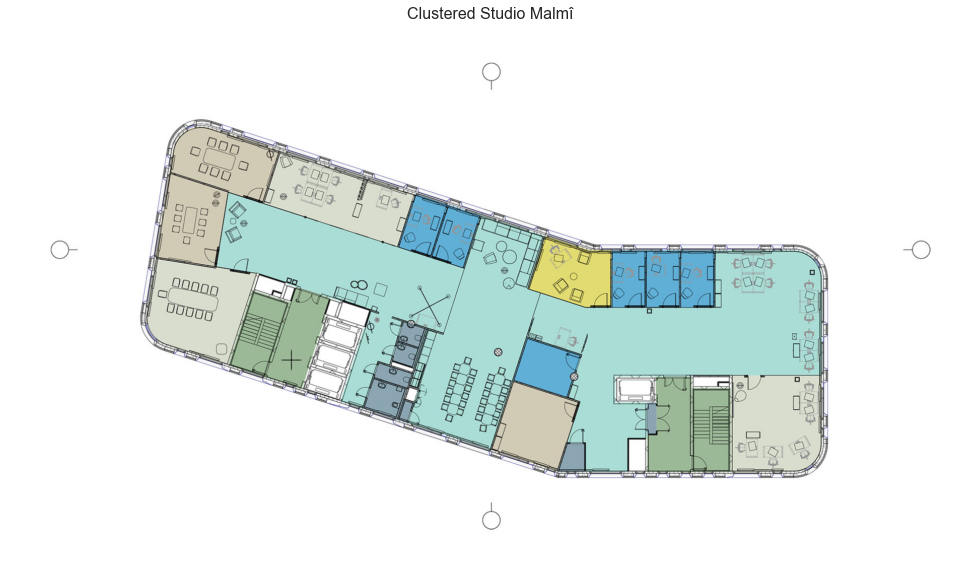

In [58]:
img=mpimg.imread('data/layout_clustered.jpg')
fig = plt.figure(figsize = (30,10))
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(img, interpolation="bilinear")
plt.axis('off')
a.set_title('Clustered Studio Malmî', fontsize=16);

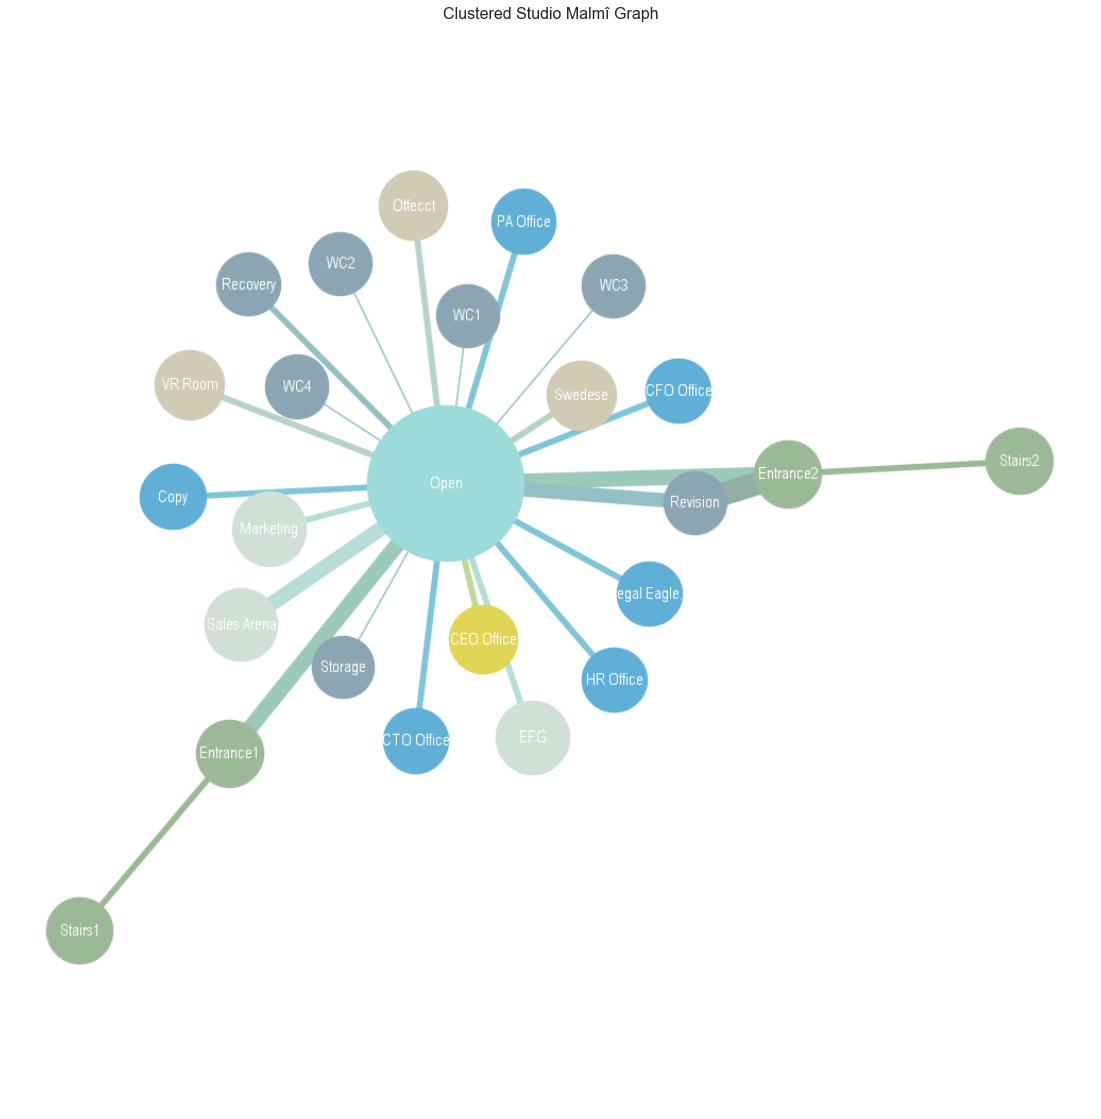

In [60]:
img=mpimg.imread('data/Graph_clustered.png')
fig = plt.figure(figsize = (20,20))
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(img, interpolation="bilinear")
plt.axis('off')
a.set_title('Clustered Studio Malmî Graph', fontsize=16);